**FIT5201 Assignment 2 Task 1: Document Clustering**  
**Student ID: 31237223**  
**Name: Darren Jer Shien Yee**  

**Question 1.1: EM Derivation and Analysis**  

**MLE for Complete Data**  

$p(k,d) = p(k)p(d|k) = \varphi k \prod\limits_{w\in d} \mu_{kw} = \varphi k \prod\limits_{w\in A} \mu_{kw}^{c(w,d)}$  
where $\varphi k$ = prior probability of class, $\mu_{kw}$ = proportion of word **w** in cluster **k** and ${c(w,d)}$ = occurence of word **w** in dictionary over any specific document **d**.  

**MLE for Incomplete Data**  
$p(d1,...,d_N) = \prod\limits_{n = 1}^N p(d_n) = \prod\limits_{n = 1}^N \sum\limits_{k = 1}^K p(d_n,z_n = k) = \prod\limits_{n = 1}^N \sum\limits_{k = 1}^K (\varphi k \prod\limits_{w\in A} \mu_{kw}^{c(w,d)})$  

**What is the main difference between MLE for Complete and Incomplete data and why is it hard to optimize)**  
The main difference as we can see is the additional summation term $\sum\limits_{k = 1}^K$ within the MLE for incomplete data which makes it incredibly difficult to maximize. The existence of this term means that if we were to use solve this MLE using log likelihood, there would be a log term outside of this term $\sum\limits_{n = 1}^N\log\sum\limits_{k = 1}^K$  which makes it hard to optimise as log of a sum is inherently a complicated mathematical concept to solve.  

**High Level Description of EM algorithm to find MLE parameter estimates**  
EM algorithm is an iterative algorithm that helps us solve the optimization problem faced in the explanation when trying to solve Maximum Likelihood Estimation with the existence of hidden variables $z$. It has two main components: E-step and M-step. During the E-step, we start by constructing a surrogate function $Q$ with a tight lower bound to $L(\theta)$ (which is the loss function for the current $\theta$ (current parameter estimation)). This forces the line constructed with $Q$ to be strictly lower than the loss function line. Then, using the Q function that we have obtained from the E-step, we perform M-Step by maximizing the Q function with respect to the current $\theta$ estimation to optain a new set of $\theta$ to be used in the next iteration's E-Step. Once converged, we should obtain a set of optimal parameters $\theta$ which maximizes the MLE.


**Question 1.2: E-Step and M-Step derivation for Document Clustering**  

**E-Step for Document Clustering**  

$\forall n,\forall k: r(z_{nk})$ based on current $\theta^t$ where $r(z_{nk}) = p(z_n = k| d_n,\theta^{old})$  

**M-step for Document Clustering**  

$Q(\theta,\theta^{old}): = \sum\limits_{n = 1}^N\sum\limits_{k = 1}^K p (z_{nk} = 1 | d_n, \theta^{old})\log p (z_{nk} = 1 | d_n, \theta)$ **where $p(z_{nk} = 1)$ equivalent to $p(z_n = k)$**  
$Q(\theta,\theta^{old}) = \sum\limits_{n = 1}^N\sum\limits_{k = 1}^K r(z_{nk}) log (\varphi k \prod\limits_{w\in A} \mu_{kw}^{c(w,d)})$  
$Q(\theta,\theta^{old}) = \sum\limits_{n = 1}^N\sum\limits_{k = 1}^K r(z_{nk}) (log \varphi k + log\prod\limits_{w\in A} \mu_{kw}^{c(w,d)})$  
$Q(\theta,\theta^{old}) = \sum\limits_{n = 1}^N\sum\limits_{k = 1}^K r(z_{nk}) (log \varphi k + \sum\limits_{w\in A} c (w,d_n)\log\mu_{kw})$  

This allows us to obtain two subterms $\varphi k$ (prior probability of k) and $\mu_{kw}$ (probability of word in the dictionary) which can maximize their log likelihoods seperately with the update estimates below by setting their derivatives to 0. 

$\varphi k = \frac{N_k}{N}$ where $N_k = \sum\limits_{n=1}^N r(z_{nk})$  
$\mu_{kw} = \frac{\sum_{n=1}^N r (z_{nk})c(w,d_n)}{\sum_{w'\in A} \sum_{n=1}^N r (z_{nk})c(w',d_n)}$



**Question 1.3: Load Task2a.txt**

In [5]:
import pandas as pd 
import numpy as np

with open('Task2a.txt', 'r') as file:
    text = file.readlines()
all([length == 2 for length in [len(line.split('\t')) for line in text]])
labels, articles = [line.split('\t')[0].strip() for line in text], [line.split('\t')[1].strip() for line in text]
docs = pd.DataFrame(data = zip(labels,articles), columns=['label', 'article'])
docs.label = docs.label.astype('category')
docs.head()

,label,article
0,sci.crypt,ripem frequently asked questions archive name ...
1,sci.crypt,ripem frequently asked questions archive name ...
2,sci.crypt,ripem frequently noted vulnerabilities archive...
3,sci.crypt,certifying authority question answered if you ...
4,sci.crypt,rubber hose cryptanalysis some sick part of me...


**Question 1.4: EM implementation (derrived from lecture code)**

In [6]:
from scipy.stats import multivariate_normal
class DocEM: 
    def __init__(self, K, tau_max=200, epsilon=0.01, random_state=None):
        self.K = K               # number of GMM clusters
        self.tau_max = tau_max   # max number of iterations
        self.epsilon = epsilon  # minimum acceptable error rate
        self.random_state = random_state
        np.random.seed(self.random_state)

    def get_params(self, deep=False):
        return {'K': self.K,
         'tau_max': self.tau_max,
         'epsilon': self.epsilon,
         'random_state': self.random_state}
    
    def __str__(self):
        params = self.get_params()
        return 'DocEM({0})'.format(','.join(['='.join([key, str(params[key])]) for key in params.keys()]))

    def __repr__(self):
        return self.__str__()
                
    def fit(self, X, verbose=False):
        N = X.shape[0] # Number of Documents 
        W = X.shape[1] # Number of Words in the Dictionary
        ## initialization:
        self.Psi_hat_ = np.array([1/self.K] * self.K) # Prior probability of k (\varphi k)
        self.Nk_hat_ = self.Psi_hat_ * N     # Estimated number of documents in each clusters                                  
        self.Mu_hat_ = np.random.rand(W, self.K)  # Estimated mean vectors for each clusters 
        r = np.zeros((N,self.K)) # Posterior matrix to store E-step values                                                 
        self.Mu_hat_historic_ = np.zeros(shape=(list(self.Mu_hat_.shape) + [self.tau_max])) # Mean value of clusters at each iteration
        self.r_historic_ = np.zeros(shape=(N, self.K, self.tau_max)) # Posterior probability of each clusters at each iteration
        self.document_count = X.toarray()
        terminate= False
        tau = 0
        # fitting loop - we iteratively take E and M steps until the termination criterion is met.
        Mu_hat_old =  np.copy(self.Mu_hat_) # Mu_hat_old is used to store the last iteration value for mu_hat
        while (not terminate):
            if verbose: print('iteration {0}'.format(tau))
            # E step:
            for n in range (N):
                for k in range(self.K):
                    ## calculate the posterior based on the estimated means,covariance and cluster size:
                    # This version of the formula was found online and I have also published it on ED for discussions
                    psi_hat_log = np.log(self.Psi_hat_[k])
                    mu_hat_log = np.log(self.Mu_hat_[:,k])
                    counts = self.document_count[n,:]
                    r[n, k] = psi_hat_log + np.sum(counts* mu_hat_log)
                self.r_historic_[:, :, tau] = r
            # M step (note that we use the vectorised notation directly which is much better and faster than using a for loop):
            for n in range (N):
                # Utilising the formula given in the assignment specs
                c = np.max(r[n,:])
                log_normalization = c + np.log(np.sum(np.exp(r[n,:] - c)))
                r[n,:] = np.exp(r[n,:] - log_normalization)
            self.Mu_hat_historic_[:, :, tau] = self.Mu_hat_
            for k in range(self.K):
                self.Psi_hat_[k] = sum(r[:,k])/N
                mu_num = np.matmul(self.document_count.T, r[:, k])
                mu_den = np.sum(mu_num)
                self.Mu_hat_[:,k] = mu_num / mu_den
            tau +=1
            # check termination condition
            terminate = ((tau == self.tau_max) or np.allclose(self.Mu_hat_, Mu_hat_old, rtol= self.epsilon))
            # record the means (neccessary for checking the termination criteria)
            Mu_hat_old = np.copy(self.Mu_hat_)

        self.Mu_hat_historic_ = self.Mu_hat_historic_[:, :, :tau]
        self.r_historic_ = self.r_historic_[:, :, :tau]

        if verbose: print(f'Converged in {tau} iterations')
        return self
        
        
    def predict_proba(self, x):
        N = x.shape[0] # Number of Documents 
        W = x.shape[1] # Number of Words in the Dictionary
        r = np.zeros((N,self.K))
        for n in range (N):
            for k in range(self.K):
                ## calculate the posterior based on the estimated means,covariance and cluster size:
                psi_hat_log = np.log(self.Psi_hat_[k])
                mu_hat_log = np.log(self.Mu_hat_[:,k])
                counts = self.document_count[n,:]
                r[n, k] = psi_hat_log + np.sum(counts* mu_hat_log)
        return r

    def predict(self, x):
        probs = self.predict_proba(x)
        preds = np.argmax(probs, axis=1)
        return preds


**Question 1.4 Pipeline**

In [13]:
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(lowercase=True,
                     stop_words='english',
                     min_df=5)
l2_norm = Normalizer(norm='l2')

docem = DocEM(K=4)

pipe = make_pipeline(cv, l2_norm, docem)
pipe.fit(articles)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(min_df=5, stop_words='english')),
                ('normalizer', Normalizer()),
                ('docem',
                 DocEM(K=4,tau_max=200,epsilon=0.01,random_state=None))])

**Question 1.5 K-means with K=4 using Lecture Code**

In [14]:
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
cv = CountVectorizer(lowercase=True,
                     stop_words='english',
                     min_df=5)
l2_norm = Normalizer(norm='l2')

km = KMeans(n_clusters=4)

pipe = make_pipeline(cv, l2_norm, km)
pipe.fit(articles)

C:\Users\manut\anaconda3\envs\FT5201\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(min_df=5, stop_words='english')),
                ('normalizer', Normalizer()),
                ('kmeans', KMeans(n_clusters=4))])

**Question 1.6 Feature Processing for PCA**

In [17]:
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import CountVectorizer

min_freq = 10
feature_options = []
for i in range(min_freq):
    cv = CountVectorizer(lowercase=True,
                     stop_words='english',
                     min_df=i+1)
    features = cv.fit_transform(raw_documents=articles)
    feature_options += [features]

features = feature_options[4] # going with min_freq = 5
l2_norm = Normalizer(norm='l2')
features_normalised = l2_norm.fit_transform(features.toarray())

**Question 1.6 Visualisation**

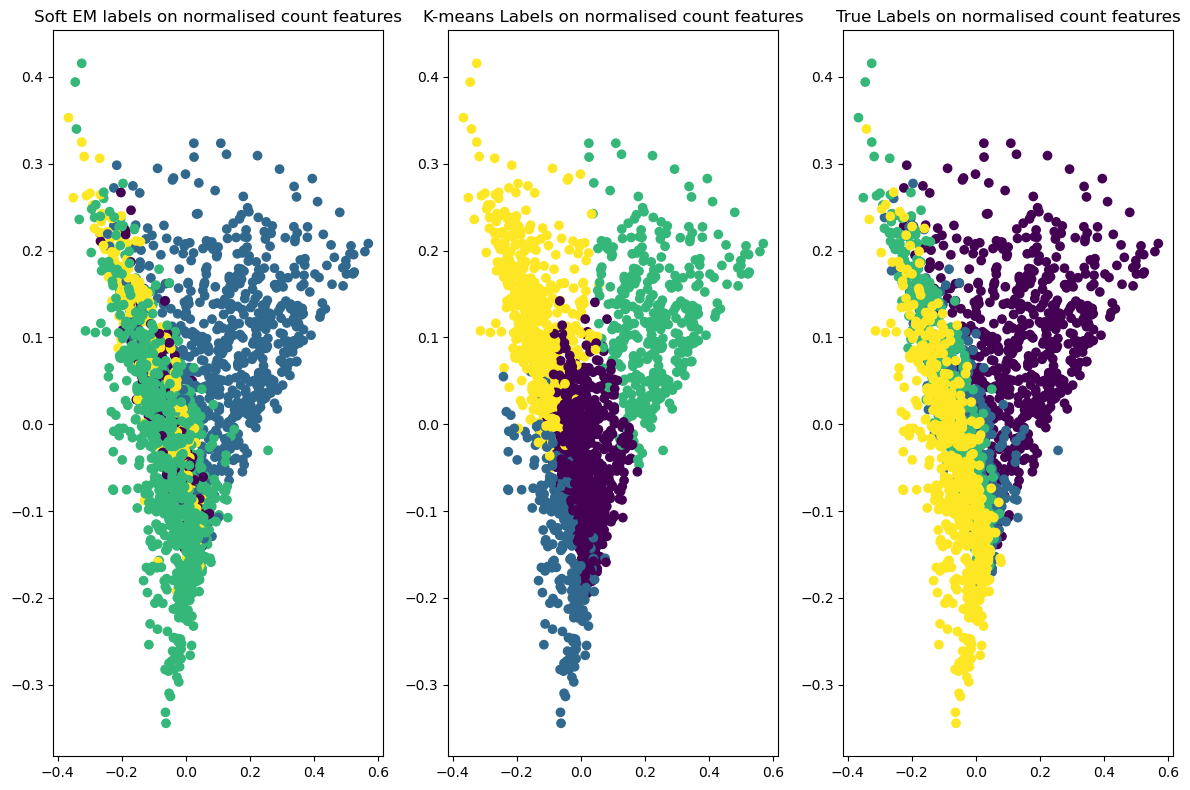

In [21]:
## perform pca code derived from lectures
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
## perform pca
pca = PCA(n_components=2)
_2D_features = pca.fit_transform(features_normalised)

## plot the kmeans outcome
_, axs = plt.subplots(1, 3, figsize=(12, 8), tight_layout=True)
axs[0].scatter(x=_2D_features[:,0],y=_2D_features[:,1], c=docem.predict(features))
axs[0].set_title('Soft EM labels on normalised count features')

## plot the original data
axs[1].scatter(x=_2D_features[:,0],y=_2D_features[:,1], c=km.labels_)
axs[1].set_title('K-means Labels on normalised count features')

## plot the original data
axs[2].scatter(x=_2D_features[:,0],y=_2D_features[:,1], c=docs.label.cat.codes)
axs[2].set_title('True Labels on normalised count features')
plt.show()
